2022-10-13

* Supervisor: Elsa DRUPAS
* Student: IRIE Bi Doubi Armel Joel

<h1><center> Practical on SVMs </h1></center>
<center> by Paul AIME, paul.aime@imt-atlantique.fr </center>

In this practical we will first scrutinize an elementary example of SVM and then see some SVM applications under Python. The packages used are `scikit-learn` (and its subpackages `svm` et `datasets`), `numpy`, `pandas` and `matplotlib`.

**Table of contents**

* [1. An elementary SVM](#1.-An-elementary-SVM)
* [2. Iris](#2.-Iris)
* [3. Chronic Kidney Disease](#3.-Chronic-Kidney-Disease)
    + [3.1 Data preparation](#3.1-Data-preparation)
    + [3.2 Data preparation for cross validation](#3.2-Data-preparation-for-cross-validation)
    + [3.3 Cross-validation and results](#3.3-Cross-validation-and-results)
* [4. SPAM](#4.-SPAM)

## 1. An elementary SVM

In the Euclidean plane $R^2$ take individuals $(1, 1), (1, 5), (5, 1)$ and $(5, 5)$, assigned to classes $−1$, $1$, $1$, $1$

Manually calculate the vector $(a, b)$ and the value of $c$ of the maximal margin classifier straight line.

Answer : 

We can formulate this problem as with Lagrange coefficient and optimize a specific function f. More details can be found in the pdf file joined to this notebook.

We finally obtain a = b = 1/2 and c = -2

In [66]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from sklearn import svm

mpl.style.use("ggplot")

In [67]:
X = np.array([[1, 1], [1, 5], [5, 1], [5, 5]])
y = np.array([-1, 1, 1, 1])

👁 [`sklearn.svm.SVC`](https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html)

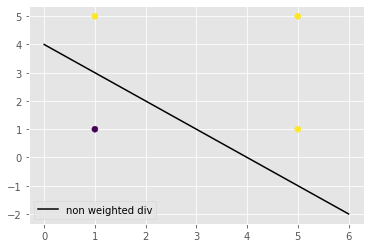

In [68]:
clf = svm.SVC(kernel="linear")
clf.fit(X, y)

w = clf.coef_[0]
a = -w[0] / w[1]

xx = np.linspace(0, 6)
yy = a * xx - clf.intercept_[0] / w[1]

fig, ax = plt.subplots()
ax.plot(xx, yy, "k-", label="non weighted div")
ax.scatter(X[:, 0], X[:, 1], c=y)
ax.legend()

So we see that on this test set the model works pretty fine.

In [69]:
print("clf.support_vectors_ = ")
print(clf.support_vectors_)
print(f"{clf.n_support_ = !s}")
print(f"{             w = !s}")

clf.support_vectors_ = 
[[1. 1.]
 [1. 5.]
 [5. 1.]]
clf.n_support_ = [1 2]
             w = [0.49975586 0.49975586]


What is the meaning of the obtained results :

- The three first points are support vectors ([[1. 1.]
 [1. 5.]
 [5. 1.]]) : they are the points that are closer to the hyperplane that best separate the two classes. 

- n_support_ gives the number [1 2] of support vector for each class.
- [0.49975586 0.49975586] are the weigths (a,b) (that we were looking for) assigned to the vectors

## 2. Iris

We will start with the famous data set “Iris” : the size in centimeters of petals and other parts of some
flowers. For every individual we have four number and the class, among *Iris setosa*, *Iris versicolor* and *Iris
virginica*. We have 150 individuals and equidistributed classes.

In [70]:
from sklearn import svm
from sklearn import datasets
from sklearn.model_selection import train_test_split

In [71]:
# Load data
iris = datasets.load_iris()

# Extract arrays
X, y = iris.data, iris.target

# Extract some useful information
num_classes = len(iris.target_names)
classes_labels = sorted(set(iris.target))

# Initialize classfier
clf = svm.SVC()

Cut of the iris data to create a training set `X_train`, `y_train` with 100 random individuals and a test set `X_test`, `y_test` with what remains.


👁 [`sklearn.model_selection.train_test_split`](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html)

Let's create training and test sets :

In [72]:
train_size = 100

X_train, X_test, y_train, y_test = train_test_split(
    X, y, train_size = 100, random_state=1, shuffle = True)

In [73]:
X_train.shape

(100, 4)

Calculate the precision and recall for each class.

In [74]:
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

In [75]:
def precision_recall_multilabels(y_true, y_pred, labels):
    recalls = []
    precisions = []
    
    for label in labels : # lets compute precision and recall for each label

        nb_true = len(y_true[y_true==label]) # number of true samples for this label
        nb_pred = len(y_pred[y_pred==label]) # number of predicted samples for this labels

        tp = min(nb_true, nb_pred)
        fp = max(0, nb_pred-nb_true)
        fn = max(0, nb_true-nb_pred)

        if nb_pred==0:
            precisions.append(0) 
            recalls.append(tp/(tp+fn))
        else : 
            precisions.append(tp/(tp+fp))
            recalls.append(tp/(tp+fn))
        
        # else: 
        #     precisions.append("Classe non présente dans l'échantillon")
        #     recalls.append("Classe non présente dans l'échantillon")
  
    return precisions, recalls


precisions, recalls = precision_recall_multilabels(y_test, y_pred, classes_labels)

print(f"{precisions = }")
print(f"{   recalls = }")

precisions = [1.0, 1.0, 0.9333333333333333]
   recalls = [1.0, 0.9473684210526315, 1.0]


Check result against `sklearn.metrics.classification_report`

In [76]:
from sklearn.metrics import classification_report

print(classification_report(y_test, y_pred, digits=4))

              precision    recall  f1-score   support

           0     1.0000    1.0000    1.0000        17
           1     1.0000    0.9474    0.9730        19
           2     0.9333    1.0000    0.9655        14

    accuracy                         0.9800        50
   macro avg     0.9778    0.9825    0.9795        50
weighted avg     0.9813    0.9800    0.9801        50



By using the class `KFold` from the package `sklearn.cross_validation`, write the code for a 10-crossed validation
and obtain average precision and recall for each class.

Use various kernel types and parameter values to see how the performances vary.

You have the choice between four kernels (option `kernel` of SVC) :

1. linear: `linear` $k(x, x') = \langle x, x' \rangle$ ;
2. polynomial: `poly` $k(x, x') = (\gamma \cdot \langle x, x' \rangle + r)^d$ ;
3. radial: `rbf` $k(x, x') = e^{-\gamma \lVert x - x' \rVert}$ (default) ;
4. sigmoid: `sigmoid` $k(x, x') = \mathrm{tanh}(\gamma \cdot \langle x, x' \rangle)$.

Parameters $\gamma$, $d$ and $r$ are written `gamma`, `degree` and `coef0`, resp. The cost parameter $C$ (see in the
class) is written `cost`.

👁 [`sklearn.model_selection.KFold`](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.KFold.html)

In [77]:
from sklearn.model_selection import KFold

In [78]:
# Once you have filled the `clfs_results` dictionnary below
# call `kfold_multimodels_report(clfs_results)`


def kfold_multimodels_report(clfs_results: dict[str, dict[str, list[list[float]]]]):
    """
    Prints a report for the results of experiments on multiple models,
    each one evaluated using k-fold cross-validation.

    The results of the experiments should be given as the 'clfs_stats'
    argument, with the following structure:

    {
        "clf_name1": {"metric1": list[list], "metric2": list[list], ...},
        "clf_name2": {"metric1": list[list], "metric2": list[list], ...},
        ...
    }

    with each list[list] being of shape (num_folds, num_classes).
    """
    clfs_stats = kfold_summarize_results(clfs_results)
    with np.printoptions(precision=2, floatmode="fixed"):
        for clf_name, clf_stats in clfs_stats.items():
            print(f"{clf_name:<15}")
            for metric_name, stats in clf_stats.items():
                print(f"{metric_name:>15}")
                for stat_name, data in stats.items():
                    print(f"{stat_name:>20}: {data}")


def kfold_summarize_results(clfs_results):
    """Computes stats on results of multi-models k-folds experiments.

    Takes:

    {
        "clf_name1": {"metric1": list[list], "metric2": list[list], ...},
        "clf_name2": {"metric1": list[list], "metric2": list[list], ...},
        ...
    }

    Returns:

    {
        "clf_name1": {"metric1": {"mean": value, "std": value ...}, ...},
        ...
    }
    """
    clfs_stats = {clf_name: {} for clf_name in clfs_results}
    for clf_name, clf_results in clfs_results.items():
        for metric, data in clf_results.items():
            clfs_stats[clf_name][metric] = {
                "mean": np.mean(data, axis=0),
                "std": np.std(data, axis=0),
            }
    return clfs_stats

In [79]:
def kfold_precisions_recalls(X, y, labels, clf, kf):
    """Returns the history of precisions and recalls through K-fold training

    Parameters
    ----------
    X, y : data
    labels : list[int]
    clf : classifier
    kf : KFold instance

    Returns
    -------
    precisions : list[list], shape (num_folds, len(labels))
    recalls : list[list], shape (num_folds, len(labels))
    """
    
    precisions, recalls = [], []
    
    for train_index, test_index in kf.split(X, y):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]

        clf.fit(X_train, y_train)
        y_pred = clf.predict(X_test)
        
        prec, rec = precision_recall_multilabels(y_test, y_pred, labels)
        precisions.append(prec)
        recalls.append(rec)

    return precisions, recalls

In [80]:
X, y = iris.data, iris.target
num_classes = len(iris.target_names)
classes_labels = sorted(set(iris.target))


clfs = {
    "linear": svm.SVC(kernel="linear", C=1.0),
    "polynomial": svm.SVC(kernel="poly", C=1.0),
    "radial": svm.SVC(kernel="rbf", C=1.0),
    "sigmoid": svm.SVC(kernel="sigmoid", C=1.0)  
}

clfs_results = {clf_name: {"precisions": None, "recalls": None} for clf_name in clfs}
clfs_results

{'linear': {'precisions': None, 'recalls': None},
 'polynomial': {'precisions': None, 'recalls': None},
 'radial': {'precisions': None, 'recalls': None},
 'sigmoid': {'precisions': None, 'recalls': None}}

In [81]:
print(X.shape)
print(y.shape)

(150, 4)
(150,)


In [82]:
kf = KFold(n_splits=10, random_state=42, shuffle=True)

for clf_name, clf in clfs.items():
    
    clfs_results[clf_name]["precisions"] = kfold_precisions_recalls(X, y, classes_labels, clf, kf)[0]  # TODO
    clfs_results[clf_name]["recalls"] = kfold_precisions_recalls(X, y, classes_labels, clf, kf)[1]   # TODO

kfold_multimodels_report(clfs_results)

linear         
     precisions
                mean: [1.00 0.99 0.95]
                 std: [0.00 0.04 0.10]
        recalls
                mean: [1.00 0.93 0.99]
                 std: [0.00 0.15 0.04]
polynomial     
     precisions
                mean: [1.00 0.99 0.91]
                 std: [0.00 0.04 0.14]
        recalls
                mean: [1.00 0.90 0.99]
                 std: [0.00 0.17 0.04]
radial         
     precisions
                mean: [1.00 0.97 0.95]
                 std: [0.00 0.07 0.12]
        recalls
                mean: [1.00 0.94 0.97]
                 std: [0.00 0.12 0.07]
sigmoid        
     precisions
                mean: [0.11 0.07 0.15]
                 std: [0.16 0.11 0.29]
        recalls
                mean: [0.40 0.30 0.40]
                 std: [0.49 0.46 0.49]


We obviously see that when we change the kernel, the value of the precision and recall may slightly change but almost stay close to 1 (apart from the sigmoid kernel that seems not to work properly).

## 3. Chronic Kidney Disease

### 3.1 Data preparation

* Fetch the file `chronic_kidney_disease_full.arff` from Moodle.
* Read the introductory comments and get acquainted with the ARFF data format.
    + For more information see http://archive.ics.uci.edu/ml/datasets/Chronic_Kidney_Disease
* Read the data into a `pandas.DataFrame` named `ckd`
    + 👁 [`scipy.io.arff.loadarff`][scipy.io.arff.loadarff], [`pandas.DataFrame`][pandas.DataFrame]
* Clean up the data
    1. Decode strings
        - 👁 [`pandas.DataFrame.columns`][pandas.DataFrame.columns], [`pandas.DataFrame.dtypes`][pandas.DataFrame.dtypes]
        - 👁 [`pandas.DataFrame.apply`][pandas.DataFrame.apply], [`pandas.Series.str.decode`][pandas.Series.str.decode]
    2. Handle nodata values (replace them with actual `np.nan`)
        - 👁 [`pandas.DataFrame.replace`][pandas.DataFrame.replace]
    3. Convert data types that are still wrong
        - 👁 [`pandas.DataFrame.apply`][pandas.DataFrame.apply], [`pandas.to_numeric`][pandas.to_numeric]
    4. Convert categorical features to corresponding data type:
        - [Pandas categorical data], [`pandas.DataFrame.astype`][pandas.DataFrame.astype]

[pandas.DataFrame.columns]: https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.columns.html
[pandas.DataFrame]: https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.html
[pandas.DataFrame.replace]: https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.replace.html
[pandas.DataFrame.dtypes]: https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.dtypes.html
[scipy.io.arff.loadarff]: https://docs.scipy.org/doc/scipy/reference/generated/scipy.io.arff.loadarff.html
[pandas.DataFrame.apply]: https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.apply.html
[pandas.Series.str.decode]: https://pandas.pydata.org/docs/reference/api/pandas.Series.str.decode.html
[pandas.to_numeric]: https://pandas.pydata.org/docs/reference/api/pandas.to_numeric.html
[Pandas categorical data]: https://pandas.pydata.org/docs/user_guide/categorical.html
[pandas.DataFrame.astype]: https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.astype.html

In [118]:
from scipy.io import arff
import pandas as pd
import os 

In [119]:
import re
ckd_path = "chronic_kidney_disease_full.arff"

data=arff.loadarff(ckd_path)

ckd=pd.DataFrame(data[0])

num_samples, num_features = ckd.shape


# Decode strings
is_str_cols = ckd.dtypes=="object"  # string where not detected correctly by the pandas 
str_columns = ckd.columns[is_str_cols]
ckd[str_columns]=ckd[str_columns].apply(lambda s:s.str.decode('utf-8'),axis=0)


# Handle nodata values
ckd=ckd.replace("?",np.nan)

# Convert remaining false string columns

other_numeric_columns=["sg","al","su"]#convert int columns into int64
ckd[other_numeric_columns]=ckd[other_numeric_columns].apply(lambda s:pd.to_numeric(s,),axis=0)

# Use categorical data type

categoric_columns=ckd.columns[ckd.dtypes=="object"]
ckd[categoric_columns]=ckd[categoric_columns].astype("category")
ckd

,age,bp,sg,al,su,rbc,pc,pcc,ba,bgr,...,pcv,wbcc,rbcc,htn,dm,cad,appet,pe,ane,class
0,48.0,80.0,1.020,1.0,0.0,NaN,normal,notpresent,notpresent,121.0,...,44.0,7800.0,5.2,yes,yes,no,good,no,no,ckd
1,7.0,50.0,1.020,4.0,0.0,NaN,normal,notpresent,notpresent,NaN,...,38.0,6000.0,NaN,no,no,no,good,no,no,ckd
2,62.0,80.0,1.010,2.0,3.0,normal,normal,notpresent,notpresent,423.0,...,31.0,7500.0,NaN,no,yes,no,poor,no,yes,ckd
3,48.0,70.0,1.005,4.0,0.0,normal,abnormal,present,notpresent,117.0,...,32.0,6700.0,3.9,yes,no,no,poor,yes,yes,ckd
4,51.0,80.0,1.010,2.0,0.0,normal,normal,notpresent,notpresent,106.0,...,35.0,7300.0,4.6,no,no,no,good,no,no,ckd
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
395,55.0,80.0,1.020,0.0,0.0,normal,normal,notpresent,notpresent,140.0,...,47.0,6700.0,4.9,no,no,no,good,no,no,notckd
396,42.0,70.0,1.025,0.0,0.0,normal,normal,notpresent,notpresent,75.0,...,54.0,7800.0,6.2,no,no,no,good,no,no,notckd
397,12.0,80.0,1.020,0.0,0.0,normal,normal,notpresent,notpresent,100.0,...,49.0,6600.0,5.4,no,no,no,good,no,no,notckd
398,17.0,60.0,1.025,0.0,0.0,normal,normal,notpresent,notpresent,114.0,...,51.0,7200.0,5.9,no,no,no,good,no,no,notckd


* Remove the "ground-truth" column and store its values aside
    + 👁 [`pandas.DataFrame.drop`][pandas.DataFrame.drop]

[pandas.DataFrame.drop]: https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.drop.html

In [120]:
y = ckd["class"]  #class 
ckd = ckd.drop(columns="class")  

* For missing numeric values, replace with the feature average
    + 👁 [`pandas.DataFrame.fillna`](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.fillna.html)
* For missing categorical values, replace with the feature most occuring value
    + 👁 [`pandas.DataFrame.mode`][pandas.DataFrame.mode] (hint: `ckd.mode().iloc[0]`)
    
[pandas.DataFrame.mode]: https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.mode.html

In [121]:
# Check the number of missing values
ckd.isna().sum(axis=0)

age        9
bp        12
sg        47
al        46
su        49
rbc      152
pc        65
pcc        4
ba         4
bgr       44
bu        19
sc        17
sod       87
pot       88
hemo      52
pcv       71
wbcc     106
rbcc     131
htn        2
dm         2
cad        2
appet      1
pe         1
ane        1
dtype: int64

In [122]:
fillna_mean_cols = ckd.columns[ckd.dtypes=="float64"]  # numerical
fillna_most_cols =  ckd.columns[ckd.dtypes=="category"]  #categorical

In [123]:
ckd[fillna_mean_cols] = ckd[fillna_mean_cols].replace(np.nan,ckd[fillna_mean_cols].mean())
ckd[fillna_most_cols] = ckd[fillna_most_cols].replace(np.nan,ckd[fillna_most_cols].mode().iloc[0])

ckd

,age,bp,sg,al,su,rbc,pc,pcc,ba,bgr,...,hemo,pcv,wbcc,rbcc,htn,dm,cad,appet,pe,ane
0,48.0,80.0,1.020,1.0,0.0,NaN,normal,notpresent,notpresent,121.000000,...,15.4,44.0,7800.0,5.200000,yes,yes,no,good,no,no
1,7.0,50.0,1.020,4.0,0.0,NaN,normal,notpresent,notpresent,148.036517,...,11.3,38.0,6000.0,4.707435,no,no,no,good,no,no
2,62.0,80.0,1.010,2.0,3.0,normal,normal,notpresent,notpresent,423.000000,...,9.6,31.0,7500.0,4.707435,no,yes,no,poor,no,yes
3,48.0,70.0,1.005,4.0,0.0,normal,abnormal,present,notpresent,117.000000,...,11.2,32.0,6700.0,3.900000,yes,no,no,poor,yes,yes
4,51.0,80.0,1.010,2.0,0.0,normal,normal,notpresent,notpresent,106.000000,...,11.6,35.0,7300.0,4.600000,no,no,no,good,no,no
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
395,55.0,80.0,1.020,0.0,0.0,normal,normal,notpresent,notpresent,140.000000,...,15.7,47.0,6700.0,4.900000,no,no,no,good,no,no
396,42.0,70.0,1.025,0.0,0.0,normal,normal,notpresent,notpresent,75.000000,...,16.5,54.0,7800.0,6.200000,no,no,no,good,no,no
397,12.0,80.0,1.020,0.0,0.0,normal,normal,notpresent,notpresent,100.000000,...,15.8,49.0,6600.0,5.400000,no,no,no,good,no,no
398,17.0,60.0,1.025,0.0,0.0,normal,normal,notpresent,notpresent,114.000000,...,14.2,51.0,7200.0,5.900000,no,no,no,good,no,no


* One-hot encode categorical features
    + 👁 [`pandas.get_dummies`][pandas.get_dummies]

[pandas.get_dummies]: https://pandas.pydata.org/docs/reference/api/pandas.get_dummies.html

In [124]:
ckd = pd.get_dummies(ckd)
ckd.shape

(400, 34)

* Normalize the data

In [125]:
def NormalizeData(data):
    return (data - np.mean(data)) / np.std(data)

ckd = NormalizeData(ckd)  # TODO
ckd.describe()

,age,bp,sg,al,su,bgr,bu,sc,sod,pot,...,dm_no,dm_yes,cad_no,cad_yes,appet_good,appet_poor,pe_no,pe_yes,ane_no,ane_yes
count,4.000000e+02,4.000000e+02,4.000000e+02,4.000000e+02,4.000000e+02,4.000000e+02,4.000000e+02,4.000000e+02,4.000000e+02,4.000000e+02,...,4.000000e+02,4.000000e+02,4.000000e+02,4.000000e+02,4.000000e+02,4.000000e+02,4.000000e+02,4.000000e+02,4.000000e+02,4.000000e+02
mean,-6.249168e-16,-4.082845e-16,1.449401e-12,-1.336153e-15,9.961476e-16,-8.969908e-16,-2.073341e-16,1.260103e-16,-9.091200e-15,4.075906e-16,...,-9.919843e-16,5.989653e-16,3.960721e-16,1.169065e-15,-1.323386e-15,2.131628e-16,-9.514611e-16,4.021783e-16,-5.281886e-16,-2.323142e-16
std,1.001252e+00,1.001252e+00,1.001252e+00,1.001252e+00,1.001252e+00,1.001252e+00,1.001252e+00,1.001252e+00,1.001252e+00,1.001252e+00,...,1.001252e+00,1.001252e+00,1.001252e+00,1.001252e+00,1.001252e+00,1.001252e+00,1.001252e+00,1.001252e+00,1.001252e+00,1.001252e+00
min,-2.918730e+00,-1.966580e+00,-2.313764e+00,-8.002896e-01,-4.377969e-01,-1.687482e+00,-1.136142e+00,-4.763339e-01,-1.447103e+01,-7.553446e-01,...,-1.370291e+00,-7.217427e-01,-3.179797e+00,-3.047887e-01,-1.954297e+00,-5.078008e-01,-2.048122e+00,-4.843221e-01,-2.357409e+00,-4.200840e-01
25%,-5.593680e-01,-4.806345e-01,-4.490180e-01,-8.002896e-01,-4.377969e-01,-6.297642e-01,-6.181044e-01,-3.872147e-01,-2.750810e-01,-2.227225e-01,...,-1.370291e+00,-7.217427e-01,3.144855e-01,-3.047887e-01,5.116929e-01,-5.078008e-01,4.882521e-01,-4.843221e-01,4.241945e-01,-4.200840e-01
50%,1.484407e-01,1.311692e-01,4.968680e-13,-1.333816e-02,-4.377969e-01,-2.950433e-01,-2.727461e-01,-2.980955e-01,-9.275247e-15,9.461269e-16,...,7.297719e-01,-7.217427e-01,3.144855e-01,-3.047887e-01,5.116929e-01,-5.078008e-01,4.882521e-01,-4.843221e-01,4.241945e-01,-4.200840e-01
75%,7.382812e-01,2.623384e-01,4.833547e-01,7.736133e-01,6.478645e-16,2.628875e-02,8.784855e-02,7.915374e-17,3.776065e-01,6.134259e-02,...,7.297719e-01,1.385535e+00,3.144855e-01,-3.047887e-01,5.116929e-01,-5.078008e-01,4.882521e-01,-4.843221e-01,4.241945e-01,-4.200840e-01
max,2.271867e+00,7.692067e+00,1.415727e+00,3.134468e+00,4.425074e+00,4.578493e+00,6.776626e+00,1.299849e+01,2.770794e+00,1.504578e+01,...,7.297719e-01,1.385535e+00,3.144855e-01,3.280961e+00,5.116929e-01,1.969276e+00,4.882521e-01,2.064742e+00,4.241945e-01,2.380476e+00


 Convert the “ground-truth”

In [126]:
np.unique(y)

array(['ckd', 'notckd'], dtype=object)

In [127]:
y = y.replace(to_replace={'ckd':1,'notckd':0})

* Get acquainted with the [input format of SVM$^{\mathrm{light}}$][SVM light], convert the data into that format, save them in a file `data.dat`.
    1. Convert the "ground-truth" data into the right numeric format into a numpy array `y`
        - 👁 [`pandas.Series.map`][pandas.Series.map], [lambda expressions]
        - 👁 [`pandas.Series.to_numpy`][pandas.Series.to_numpy]
    2. Extract the data in a numpy array `X`
        - 👁 [`pandas.DataFrame.to_numpy`][pandas.DataFrame.to_numpy]
    3. Write `data.dat` from `X` and `y`
        * 👁 [`str.join`][str.join], `f-strings`
        * 👁 [`open`][open], [`io.TextIOBase.write`][io.TextIOBase.write]
    
[SVM light]: https://www.cs.cornell.edu/people/tj/svm_light/
[pandas.Series.map]: https://pandas.pydata.org/docs/reference/api/pandas.Series.map.html
[lambda expressions]: https://docs.python.org/3/tutorial/controlflow.html#lambda-expressions
[pandas.Series.to_numpy]: https://pandas.pydata.org/docs/reference/api/pandas.Series.to_numpy.html
[pandas.DataFrame.to_numpy]: https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.to_numpy.html
[str.join]: https://docs.python.org/3/library/stdtypes.html?highlight=str.join#str.join
[open]: https://docs.python.org/3/library/functions.html#open
[io.TextIOBase.write]: https://docs.python.org/3/library/io.html#io.TextIOBase.write

### 3.2 Data preparation for cross validation

Read `data.dat` and shuffle lines. Divide in ten parts, put every test corpus into `test_xx.dat` for `xx=00..09`, and every training corpus into `train_xx.dat` for `xx=00..09`.

In [128]:
classes_labels = sorted(set(y))
classes_labels

[0, 1]

In [129]:
X = ckd
num_classes = len(np.unique(y))
classes_labels = sorted(set(y))

### 3.3 Cross-validation and results

* Download and install SVM$^{\mathrm{light}}$ from https://www.cs.cornell.edu/people/tj/svm_light/index.html
* Find out the command line syntax and run SVM$^{\mathrm{light}}$ ten times from within Python on the `test_xx.dat` and `train_xx.dat` files.
* Capture the data returned from SVM$^{\mathrm{light}}$, and parse it to extract runtime, error, precision and recall
    + 👁 [`subprocess.run`][subprocess.run]
    + 👁 [`subprocess.CompletedProcess.stdout`][CompletedProcess], [`bytes.decode`][decode]
    + 👁 [`re.match`][re.match], [regex101](https://regex101.com/r/fnnhtb/1)
* Calculate the average runtime, error, precision and recall.
* Use various kernels and play with the parameters to see whether the results can be improved, without
affecting performance too much.

[subprocess.run]: https://docs.python.org/3/library/subprocess.html#subprocess.run
[CompletedProcess]: https://docs.python.org/3/library/subprocess.html#subprocess.CompletedProcess
[decode]: https://docs.python.org/3/library/stdtypes.html#bytes.decode
[re.match]: https://docs.python.org/3/library/re.html#re.match

In [130]:
def kfold_precisions_recalls_ckd(X, y, labels, clf, kf):
    """Returns the history of precisions and recalls through K-fold training

    Parameters
    ----------
    X, y : data
    labels : list[int]
    clf : classifier
    kf : KFold instance

    Returns
    -------
    precisions : list[list], shape (num_folds, len(labels))
    recalls : list[list], shape (num_folds, len(labels))
    """
    
    precisions, recalls = [], []
    
    for train_index, test_index in kf.split(X, y):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]

        clf.fit(X_train, y_train)
        y_pred = clf.predict(X_test)
        
        prec, rec = precision_recall_multilabels(y_test, y_pred, labels)
        precisions.append(prec)
        recalls.append(rec)

    return precisions, recalls

In [131]:
clfs = {
    "linear": svm.SVC(kernel="linear", C=1.0),
    "polynomial": svm.SVC(kernel="poly", C=1.0),
    "rbf": svm.SVC(kernel="rbf", C=1.0),
    "sigmoid": svm.SVC(kernel="sigmoid", C=1.0)  
}

clfs_results = {clf_name: {"precisions": None, "recalls": None} for clf_name in clfs}
clfs_results

{'linear': {'precisions': None, 'recalls': None},
 'polynomial': {'precisions': None, 'recalls': None},
 'rbf': {'precisions': None, 'recalls': None},
 'sigmoid': {'precisions': None, 'recalls': None}}

In [132]:
kf = KFold(n_splits=10, random_state=42, shuffle=True)

for clf_name, clf in clfs.items():
    
    clfs_results[clf_name]["precisions"] = kfold_precisions_recalls_ckd(X, y, classes_labels, clf, kf)[0] 
    clfs_results[clf_name]["recalls"] = kfold_precisions_recalls_ckd(X, y, classes_labels, clf, kf)[1]

kfold_multimodels_report(clfs_results)

linear         
     precisions
                mean: [0.99 1.00]
                 std: [0.03 0.00]
        recalls
                mean: [1.00 0.99]
                 std: [0.00 0.02]
polynomial     
     precisions
                mean: [1.00 0.99]
                 std: [0.00 0.02]
        recalls
                mean: [0.97 1.00]
                 std: [0.05 0.00]
rbf            
     precisions
                mean: [1.00 1.00]
                 std: [0.00 0.01]
        recalls
                mean: [0.99 1.00]
                 std: [0.02 0.00]
sigmoid        
     precisions
                mean: [1.00 1.00]
                 std: [0.00 0.00]
        recalls
                mean: [1.00 1.00]
                 std: [0.00 0.00]


Compare with scikit-learn

In [34]:
from sklearn.metrics import precision_score, recall_score

clf = ...

precisions = []
recalls = []
for ...:  # TODO
    ...  # TODO

sklearn_results = pd.DataFrame({"precision": precisions, "recall": recalls})
sklearn_results

,precision,recall
0,1.0,0.950000
1,1.0,0.928571
2,1.0,0.846154
3,1.0,0.920000
4,1.0,0.961538
5,1.0,0.916667
6,1.0,0.900000
7,1.0,0.913043
8,1.0,1.000000
9,1.0,0.888889


## 4. SPAM

For those who finished the previous exercise and are still motivated for another example, which they can continue at home, fetch the SPAM dataset from Hewlett-Packard : https://archive.ics.uci.edu/ml/datasets/Spambase

It contains 4 061 individuals with 57 features and the class (SPAM or not SPAM). There are 39,4% SPAM individuals and 60,59% not SPAM individuals. It is preferable to avoid false positives, see if you can get zero false positives and check how many SPAMs pass the filter then.

In [142]:
# Loading the dataset
data = pd.read_table('..\spambase\spambase.data', sep =',')


# labels and features selection
labels = data.iloc[:, -1:]             
features = data.iloc[:, :-1]  

1
0    0.606087
1    0.393913
dtype: float64


<BarContainer object of 2 artists>

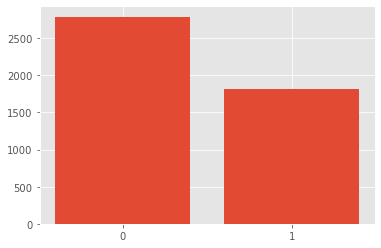

In [143]:
print(labels.value_counts()/len(label))
ind = ["0", "1"]
plt.bar(ind, labels.value_counts()) #

Data are unbalanced.

In [139]:
features.describe()

,0,0.64,0.64.1,0.1,0.32,0.2,0.3,0.4,0.5,0.6,...,0.39,0.40,0.41,0.42,0.778,0.43,0.44,3.756,61,278
count,4600.000000,4600.000000,4600.000000,4600.000000,4600.000000,4600.000000,4600.000000,4600.000000,4600.000000,4600.000000,...,4600.000000,4600.000000,4600.000000,4600.000000,4600.000000,4600.000000,4600.000000,4600.000000,4600.000000,4600.000000
mean,0.104576,0.212922,0.280578,0.065439,0.312222,0.095922,0.114233,0.105317,0.090087,0.239465,...,0.031876,0.038583,0.139061,0.016980,0.268960,0.075827,0.044248,5.191827,52.170870,283.290435
std,0.305387,1.290700,0.504170,1.395303,0.672586,0.273850,0.391480,0.401112,0.278643,0.644816,...,0.285765,0.243497,0.270377,0.109406,0.815726,0.245906,0.429388,31.732891,194.912453,606.413764
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.588000,6.000000,35.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.065000,0.000000,0.000000,0.000000,0.000000,2.275500,15.000000,95.000000
75%,0.000000,0.000000,0.420000,0.000000,0.382500,0.000000,0.000000,0.000000,0.000000,0.160000,...,0.000000,0.000000,0.188000,0.000000,0.314250,0.052000,0.000000,3.705250,43.000000,265.250000
max,4.540000,14.280000,5.100000,42.810000,10.000000,5.880000,7.270000,11.110000,5.260000,18.180000,...,10.000000,4.385000,9.752000,4.081000,32.478000,6.003000,19.829000,1102.500000,9989.000000,15841.000000


In [144]:
# Normalization
def NormalizeData(data):
    return (data - np.mean(data)) / np.std(data)

features = NormalizeData(features)  # TODO
features.describe()

,0,0.64,0.64.1,0.1,0.32,0.2,0.3,0.4,0.5,0.6,...,0.39,0.40,0.41,0.42,0.778,0.43,0.44,3.756,61,278
count,4.600000e+03,4.600000e+03,4.600000e+03,4.600000e+03,4.600000e+03,4.600000e+03,4.600000e+03,4.600000e+03,4.600000e+03,4.600000e+03,...,4.600000e+03,4.600000e+03,4.600000e+03,4.600000e+03,4.600000e+03,4.600000e+03,4.600000e+03,4.600000e+03,4.600000e+03,4.600000e+03
mean,-1.245043e-15,1.108546e-15,-6.876384e-15,-4.160712e-16,7.111944e-15,4.132998e-15,-7.921200e-15,4.668126e-15,-1.314212e-14,2.178523e-15,...,-1.436743e-15,-2.314779e-15,1.729028e-15,1.595306e-15,1.004215e-15,3.291087e-15,-1.559954e-15,-5.823542e-16,5.848462e-16,1.010798e-15
std,1.000109e+00,1.000109e+00,1.000109e+00,1.000109e+00,1.000109e+00,1.000109e+00,1.000109e+00,1.000109e+00,1.000109e+00,1.000109e+00,...,1.000109e+00,1.000109e+00,1.000109e+00,1.000109e+00,1.000109e+00,1.000109e+00,1.000109e+00,1.000109e+00,1.000109e+00,1.000109e+00
min,-3.424753e-01,-1.649840e-01,-5.565759e-01,-4.690469e-02,-4.642614e-01,-3.503089e-01,-2.918283e-01,-2.625921e-01,-3.233412e-01,-3.714103e-01,...,-1.115585e-01,-1.584710e-01,-5.143772e-01,-1.552149e-01,-3.297548e-01,-3.083916e-01,-1.030597e-01,-1.321116e-01,-2.625611e-01,-4.655586e-01
25%,-3.424753e-01,-1.649840e-01,-5.565759e-01,-4.690469e-02,-4.642614e-01,-3.503089e-01,-2.918283e-01,-2.625921e-01,-3.233412e-01,-3.714103e-01,...,-1.115585e-01,-1.584710e-01,-5.143772e-01,-1.552149e-01,-3.297548e-01,-3.083916e-01,-1.030597e-01,-1.135799e-01,-2.369058e-01,-4.094851e-01
50%,-3.424753e-01,-1.649840e-01,-5.565759e-01,-4.690469e-02,-4.642614e-01,-3.503089e-01,-2.918283e-01,-2.625921e-01,-3.233412e-01,-3.714103e-01,...,-1.115585e-01,-1.584710e-01,-2.739460e-01,-1.552149e-01,-3.297548e-01,-3.083916e-01,-1.030597e-01,-9.191234e-02,-1.907262e-01,-3.105320e-01
75%,-3.424753e-01,-1.649840e-01,2.765673e-01,-4.690469e-02,1.045010e-01,-3.503089e-01,-2.918283e-01,-2.625921e-01,-3.233412e-01,-1.232505e-01,...,-1.115585e-01,-1.584710e-01,1.810238e-01,-1.552149e-01,5.552688e-02,-9.690591e-02,-1.030597e-01,-4.685167e-02,-4.705634e-02,-2.975262e-02
max,1.452553e+01,1.089998e+01,9.560163e+00,3.063795e+01,1.440534e+01,2.112362e+01,1.828073e+01,2.743842e+01,1.855591e+01,2.782575e+01,...,3.488599e+01,1.785191e+01,3.555770e+01,3.715035e+01,3.948942e+01,2.410601e+01,4.608161e+01,3.458328e+01,5.098653e+01,2.565806e+01


In [151]:
# let's apply svm on it
X = features
y = labels
num_classes = len(np.unique(y))
classes_labels = sorted(set(y))

In [ ]:
# Initialize classfier
clf = svm.SVC()

# split the dataset
X_train, X_test, y_train, y_test = train_test_split(
    X, y, random_state=1, shuffle = True)

# Training the model
clf.fit(X_train, y_train)
#predition
y_pred = clf.predict(X_test)
y_pred.shape

In [152]:
## results
print(classification_report(y_test, y_pred, digits=4))

              precision    recall  f1-score   support

           0     0.9385    0.9572    0.9477       701
           1     0.9310    0.9020    0.9163       449

    accuracy                         0.9357      1150
   macro avg     0.9347    0.9296    0.9320      1150
weighted avg     0.9356    0.9357    0.9355      1150



Most of the data are predicted to be non spam. we can try to solve this problem by resampling the dataset